In [1]:
import tensorflow as tf
import math, re, os
from rosneft_utils import contest_metric,sive_diam_pan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
def get_submit(cnt_preds, dist_preds, indices):
    submit = []
    for idx, cnt, dist in zip(indices, cnt_preds, dist_preds):
        cnt = int(cnt)
        sizes = np.random.choice(sive_diam_pan, size=cnt, p=dist / np.sum(dist))
        submit.extend([{
            "ImageId": idx,
            "prop_size": sizes[i]
        } for i in range(cnt)])
    return pd.DataFrame.from_records(submit)

In [3]:
TARGET_SIZE = [384,384]
AUTO = tf.data.experimental.AUTOTUNE


In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment 
    # variable is set. On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 15
NUM_FOLDS = 5
RANDOM_STATE = 800
start_lr = 0.00001
min_lr = 0.00005
max_lr = 0.0002
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

1e-05 7.013265920000002e-05


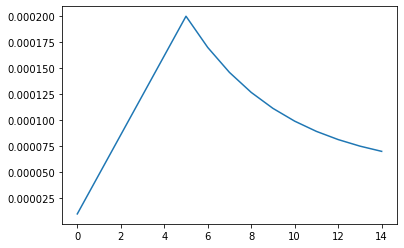

In [6]:

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [7]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

In [8]:
def decode_image(filename, label=None, image_size=TARGET_SIZE):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.
#     try:
#         if image.shape[0]>image.shape[1]:
#             image = tf.image.transpose(image)
#         image = tf.image.crop_to_bounding_box(image, 0, int((image.shape[1] - image.shape[0])*.75) , int(image.shape[0]), int(image.shape[0]))
#     except TypeError:
#         pass
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [9]:
def get_model():
    with strategy.scope():
        inp1 = tf.keras.layers.Input(shape = (*TARGET_SIZE, 3), name = 'inp1')
        pretrained_model = tf.keras.applications.MobileNetV2(weights = 'imagenet', include_top = False)
        pretrained_model.trainable = True

        x = pretrained_model(inp1, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        output = tf.keras.layers.Dense(9, activation = 'softmax')(x)

        model = tf.keras.models.Model(inputs = [inp1], outputs = [output])

        # opt = tfa.optimizers.SWA(opt)

        model.compile(
            optimizer = 'adam',
            loss = 'mse',
            metrics = ['mse']
        )

        return model

In [10]:
TRAIN_FOLDER = '../input/rosneft-challenge/RPCC_train/train/'
train = pd.read_csv('../input/rosneft-challenge/RPCC_labels.csv')
uniques = train[-train[['16','18','20','25']].duplicated()]
uniques = uniques[-uniques['18'].isna()].reset_index(drop=True)

In [11]:
folds = KFold(n_splits=NUM_FOLDS,shuffle=True,random_state=RANDOM_STATE)
scores = []
for i, (train_idx,val_idx) in enumerate(folds.split(uniques)):

    train_part, val_part =  uniques.loc[train_idx] , uniques.loc[val_idx] 
    train_part = pd.merge(train, train_part[['16','18','20','25']],on=['16','18','20','25'] ,how='inner')
    val_part = pd.merge(train, val_part[['16','18','20','25']],on=['16','18','20','25'] ,how='inner')
    train_paths = train_part.ImageId.apply(lambda x : TRAIN_FOLDER+ str(x)+'.jpg')[-train_part['18'].isna()]
    train_labels = train_part[train.columns[7:16]][-train_part['18'].isna()]

    valid_paths = val_part.ImageId.apply(lambda x : TRAIN_FOLDER+ str(x)+'.jpg')[-val_part['18'].isna()]
    valid_labels = val_part[val_part.columns[7:16]][-val_part['18'].isna()]
    
    model = get_model()

    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((train_paths, train_labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .cache()
        .repeat()
        .shuffle(1024)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((valid_paths, valid_labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .cache()
        .prefetch(AUTO)
    )

    STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

    history = model.fit(train_dataset,  epochs=EPOCHS  ,  steps_per_epoch=STEPS_PER_EPOCH,verbose = 2,
                        validation_data = valid_dataset,callbacks =[lr_callback]
    )
    
    validation_shit = val_part[-val_part['18'].isna()].copy()[list(val_part.columns[1:21])+['prop_count','ImageId','fraction']]
    prediction_shit = val_part[-val_part['18'].isna()].copy()[list(val_part.columns[1:21])+['prop_count','ImageId']]
    
    prediction_shit[list(val_part.columns[1:21])] = prediction_shit[list(val_part.columns[1:21])].fillna(0)
    prediction_shit[val_part.columns[7:16]]  = model.predict(valid_dataset)
    pred_sub = get_submit(np.ones_like(prediction_shit.ImageId) *1700,    prediction_shit[list(val_part.columns[1:21])].values ,   prediction_shit.ImageId )
    print(f'fold {i}')
    print(contest_metric(validation_shit,pred_sub ))
    scores.append(contest_metric(validation_shit,pred_sub ))

9412608/9406464 [==============================] - 0s 0us/step

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
75/75 - 47s - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0177 - val_mse: 0.0177

Epoch 00002: LearningRateScheduler reducing learning rate to 4.8e-05.
Epoch 2/15
75/75 - 12s - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0071 - val_mse: 0.0071

Epoch 00003: LearningRateScheduler reducing learning rate to 8.6e-05.
Epoch 3/15
75/75 - 12s - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0173 - val_mse: 0.0173

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000124.
Epoch 4/15
75/75 - 12s - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0047 - val_mse: 0.0047

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000162.
Epoch 5/15
75/75 - 11s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0031 - val_mse: 0.0031

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 6/15
75/75 - 11s - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0

In [12]:
scores

[(0.16349471349448896, 0.03174458591511485, 0.36111990486355017),
 (0.1369375049062297, 0.03766309286059824, 0.28584912297467685),
 (0.16096476367932727, 0.04772312310706622, 0.33082722453771884),
 (0.15057996676058727, 0.046979067128380264, 0.30598131620889774),
 (0.14386702811897037, 0.03297866515904556, 0.31019957255885755)]

In [13]:
train_paths = train.ImageId.apply(lambda x : TRAIN_FOLDER+ str(x)+'.jpg')[-train['18'].isna()]
train_labels = train[train.columns[7:16]][-train['18'].isna()]



model = get_model()

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(train_dataset,  epochs=EPOCHS  ,  steps_per_epoch=STEPS_PER_EPOCH,callbacks =[lr_callback]
)




Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
94/94 [==============================] - 14s 152ms/step - loss: 0.0155 - mse: 0.0155

Epoch 00002: LearningRateScheduler reducing learning rate to 4.8e-05.
Epoch 2/15
94/94 [==============================] - 14s 152ms/step - loss: 0.0119 - mse: 0.0119

Epoch 00003: LearningRateScheduler reducing learning rate to 8.6e-05.
Epoch 3/15
94/94 [==============================] - 14s 153ms/step - loss: 0.0067 - mse: 0.0067

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000124.
Epoch 4/15
94/94 [==============================] - 14s 152ms/step - loss: 0.0052 - mse: 0.0052

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000162.
Epoch 5/15
94/94 [==============================] - 14s 152ms/step - loss: 0.0079 - mse: 0.0079

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 6/15
94/94 [==============================] - 14s 151ms/step - loss: 0.0073 - mse: 0.0073

In [14]:
model.save_weights('model_count_weights')